In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(style='whitegrid', font_scale=0.9, rc={"lines.linewidth": 1.4,
                                           'lines.markersize': 1.6}, font="serif")

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size

/Users/dylancromer/.venvs/maszcal/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


In [3]:
import numpy as np
import emcee
import maszcal.lensing
import maszcal.data.obs
from maszcal.data.sims import NBatta2010
import maszcal.likelihoods
import maszcal.fitutils

In [4]:
DATA_DIR = '../data/NBatta2010/single-mass-bin-fits/'

In [5]:
LOWER_RADIUS_CUT = 0.125
UPPER_RADIUS_CUT = 3

nbatta_sims = NBatta2010('../data/NBatta2010/').cut_radii(LOWER_RADIUS_CUT, UPPER_RADIUS_CUT)

In [6]:
zs = nbatta_sims.redshifts

In [7]:
rs = nbatta_sims.radii

z_index = 5
cluster_index = 14

z = zs[z_index]

wl_data = nbatta_sims.wl_signals[:, z_index, cluster_index]

In [8]:
COVARIANCE_REDUCTION_FACTOR = 1/400


act_covariance = (maszcal.data.obs.ActHsc2018.covariance('../data/act-hsc/', rs)
                  * COVARIANCE_REDUCTION_FACTOR)
act_r_esd_cov = np.diagflat(rs).T @ act_covariance @ np.diagflat(rs)
act_fisher = np.linalg.inv(act_r_esd_cov)

In [9]:
nfw_model = maszcal.lensing.SingleMassNfwLensingSignal(
    redshift=np.array([zs[z_index]]),
    delta=500,
    mass_definition='crit',
)

baryon_model = maszcal.lensing.SingleBaryonLensingSignal(
    redshift=np.array([zs[z_index]]),
    delta=500,
    mass_definition='crit',
)

In [10]:
NFW_PARAM_MINS = np.array([np.log(6e12), 0])
NFW_PARAM_MAXES = np.array([np.log(5e15), 6])

CM_PARAM_MINS = np.array([np.log(6e12)])
CM_PARAM_MAXES = np.array([np.log(5e15)])

BARYON_PARAM_MINS = np.array([np.log(6e12), 0, 2])
BARYON_PARAM_MAXES = np.array([np.log(5e15), 6, 7])

BARYON_CM_PARAM_MINS = np.array([np.log(6e12), 2])
BARYON_CM_PARAM_MAXES = np.array([np.log(5e15), 7])

In [11]:
def _log_like(params, radii, esd_model_func, esd_data, fisher_matrix):
    if np.any(params) < 0:
        return -np.inf

    esd_model = esd_model_func(radii, params).flatten()
    esd_data = esd_data.flatten()

    return maszcal.likelihoods.log_gaussian_shape(radii*esd_model, radii*esd_data, fisher_matrix)


def _log_prior(params, param_mins, param_maxes):
    if np.all(
        (param_mins < params) & (params < param_maxes)
    ):
        return 0
    else:
        return -np.inf
    
    
def _log_prob(params, radii, esd_model_func, esd_data, fisher_matrix, param_mins, param_maxes):
    prior = _log_prior(params, param_mins, param_maxes)
    if prior == np.inf:
        return prior
    else:
        return _log_like(params, radii, esd_model_func, esd_data, fisher_matrix)


def _get_best_fit(esd_data, radii, esd_model_func, fisher_matrix, param_mins, param_maxes):
    def func_to_minimize(params):
        return -_log_prob(
            params,
            radii,
            esd_model_func,
            esd_data,
            fisher_matrix,
            param_mins,
            param_maxes,
        )
    
    return maszcal.fitutils.global_minimize(func_to_minimize, param_mins,
                                            param_maxes, 'global-differential-evolution')

In [12]:
import maszcal.concentration
con_model = maszcal.concentration.ConModel('500c', cosmology=nbatta_sims.cosmology)

In [13]:
def nfw_model_func(radii, params):
    return nfw_model.esd(radii, params[None, :])


def log_prob_nfw(params):
    return _log_prob(
        params,
        rs,
        nfw_model_func,
        wl_data,
        act_fisher,
        NFW_PARAM_MINS,
        NFW_PARAM_MAXES,
    )

    
def cm_model_func(radii, mus):
    masses = np.exp(mus)
    cons = con_model.c(masses, np.array([z]), '500c').flatten()
    params = np.stack((mus, cons)).T
    return nfw_model.esd(radii, params)


def log_prob_cm(params):
    return _log_prob(
        params,
        rs,
        cm_model_func,
        wl_data,
        act_fisher,
        CM_PARAM_MINS,
        CM_PARAM_MAXES,
    )


def baryon_model_func(radii, params):
    alpha = np.array([0.9])
    gamma = np.array([0.2])
    params = np.concatenate((params[:2], alpha, params[2:], gamma))
    return baryon_model.esd(radii, params[None, :])

    
def log_prob_bary(params):
    return _log_prob(
        params,
        rs,
        baryon_model_func,
        wl_data,
        act_fisher,
        BARYON_PARAM_MINS,
        BARYON_PARAM_MAXES,
    )


def baryon_cm_model_func(radii, params):
    mu = params[0:1]
    alpha = np.array([0.9])
    beta = params[1:2]
    gamma = np.array([0.2])

    mass = np.exp(mu)
    con_model = maszcal.concentration.ConModel('500c', cosmology=nbatta_sims.cosmology)
    con = con_model.c(mass, np.array([z]), '500c').flatten()

    params = np.concatenate((mu, con, alpha, beta, gamma))
    params = params[None, :]
    return baryon_model.esd(radii, params)


def log_prob_bary_cm(params):
    return _log_prob(
        params,
        rs,
        baryon_cm_model_func,
        wl_data,
        act_fisher,
        BARYON_CM_PARAM_MINS,
        BARYON_CM_PARAM_MAXES,
    )

In [14]:
nfw_max_like = _get_best_fit(
    wl_data,
    rs,
    nfw_model_func,
    act_fisher,
    NFW_PARAM_MINS,
    NFW_PARAM_MAXES,
)

cm_max_like = _get_best_fit(
    wl_data,
    rs,
    cm_model_func,
    act_fisher,
    CM_PARAM_MINS,
    CM_PARAM_MAXES,
)

baryon_max_like = _get_best_fit(
    wl_data,
    rs,
    baryon_model_func,
    act_fisher,
    BARYON_PARAM_MINS,
    BARYON_PARAM_MAXES,
)

baryon_cm_max_like = _get_best_fit(
    wl_data,
    rs,
    baryon_cm_model_func,
    act_fisher,
    BARYON_CM_PARAM_MINS,
    BARYON_CM_PARAM_MAXES,
)

/Users/dylancromer/Development/github/dylancromer/maszcal/maszcal/nfw.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return self.radius_delta(zs, masses)[:, :, None]/cons[None, None, :]
/Users/dylancromer/Development/github/dylancromer/maszcal/maszcal/nfw.py:89: RuntimeWarning: invalid value encountered in true_divide
  return (self._delta * cons**3)/(3 * (np.log(1+cons) - cons/(1+cons)))
/Users/dylancromer/Development/github/dylancromer/maszcal/maszcal/nfw.py:96: RuntimeWarning: divide by zero encountered in arctanh
  + 4 * np.arctanh(np.sqrt((1-x) / (1+x))) / ((x**2 - 1) * np.sqrt(1 - x**2))
/Users/dylancromer/Development/github/dylancromer/maszcal/maszcal/nfw.py:96: RuntimeWarning: divide by zero encountered in log
  + 4 * np.arctanh(np.sqrt((1-x) / (1+x))) / ((x**2 - 1) * np.sqrt(1 - x**2))
/Users/dylancromer/Development/github/dylancromer/maszcal/maszcal/nfw.py:96: RuntimeWarning: invalid value encountered in add
  + 4 * np.arctanh(np.sqrt((1-x) / (1+x))) / ((x

In [15]:
nwalkers = 600
nfw_ndim = 2
cm_ndim = 1
baryon_ndim = 3
baryon_cm_ndim = 2

nfw_pos = [nfw_max_like + 1e-2*np.random.randn(nfw_ndim) for i in range(nwalkers)]
cm_pos = [cm_max_like + 1e-2*np.random.randn(cm_ndim) for i in range(nwalkers)]
baryon_pos = [baryon_max_like + 1e-2*np.random.randn(baryon_ndim) for i in range(nwalkers)]
baryon_cm_pos = [baryon_cm_max_like + 1e-2*np.random.randn(baryon_cm_ndim) for i in range(nwalkers)]

In [16]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [17]:
os.cpu_count()

12

In [18]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, nfw_ndim, log_prob_nfw)

In [19]:
import sys
from multiprocessing import Pool

nsteps = 1200
width = 30

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, nfw_ndim, log_prob_nfw, pool=pool)
    sampler.run_mcmc(nfw_pos, nsteps, progress=True)

100%|██████████| 1200/1200 [01:09<00:00, 17.25it/s]


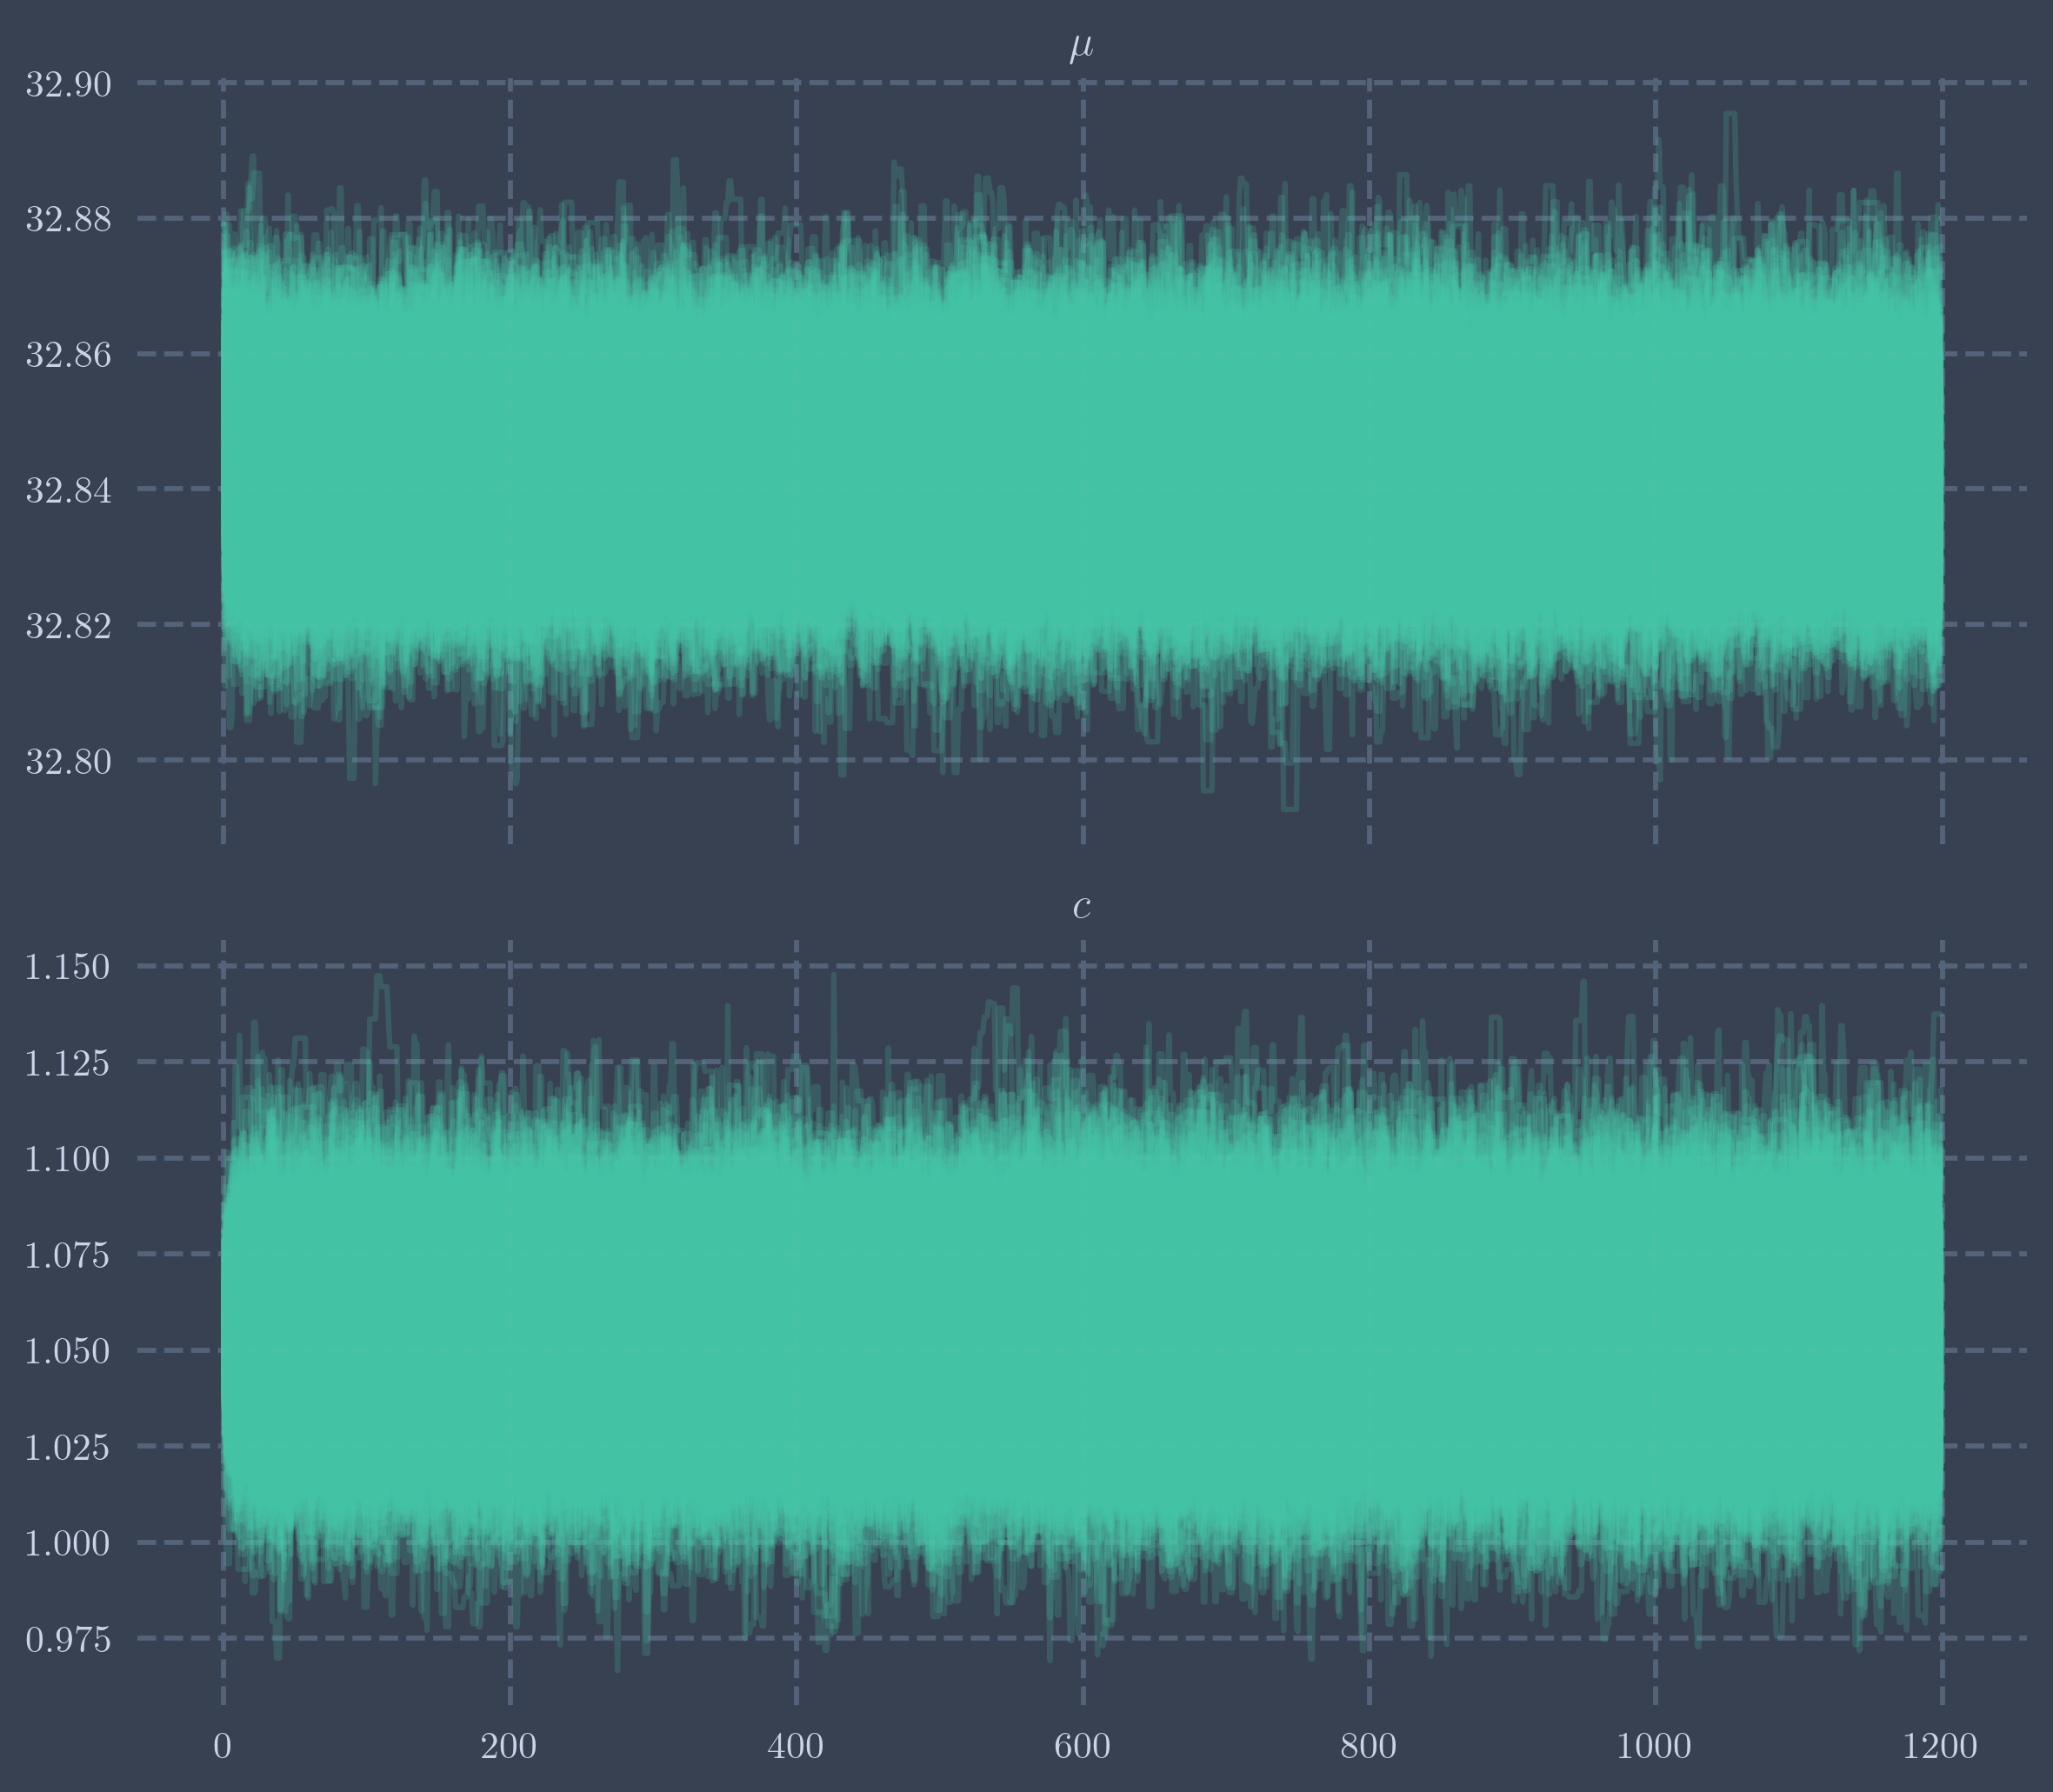

In [20]:
param_names = [r'$\mu$', r'$c$']
colors = ['#5b99e2', '#48c7a9']
fig,ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, color=colors[1], alpha=0.2)
    ax[i].set_title(param_names[i])

In [21]:
nfw_samples_to_plot = sampler.chain[:, 200:, :].reshape((-1, nfw_ndim))

In [22]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, cm_ndim, log_prob_cm, pool=pool)
    sampler.run_mcmc(cm_pos, nsteps, progress=True)

100%|██████████| 1200/1200 [13:45<00:00,  1.45it/s]


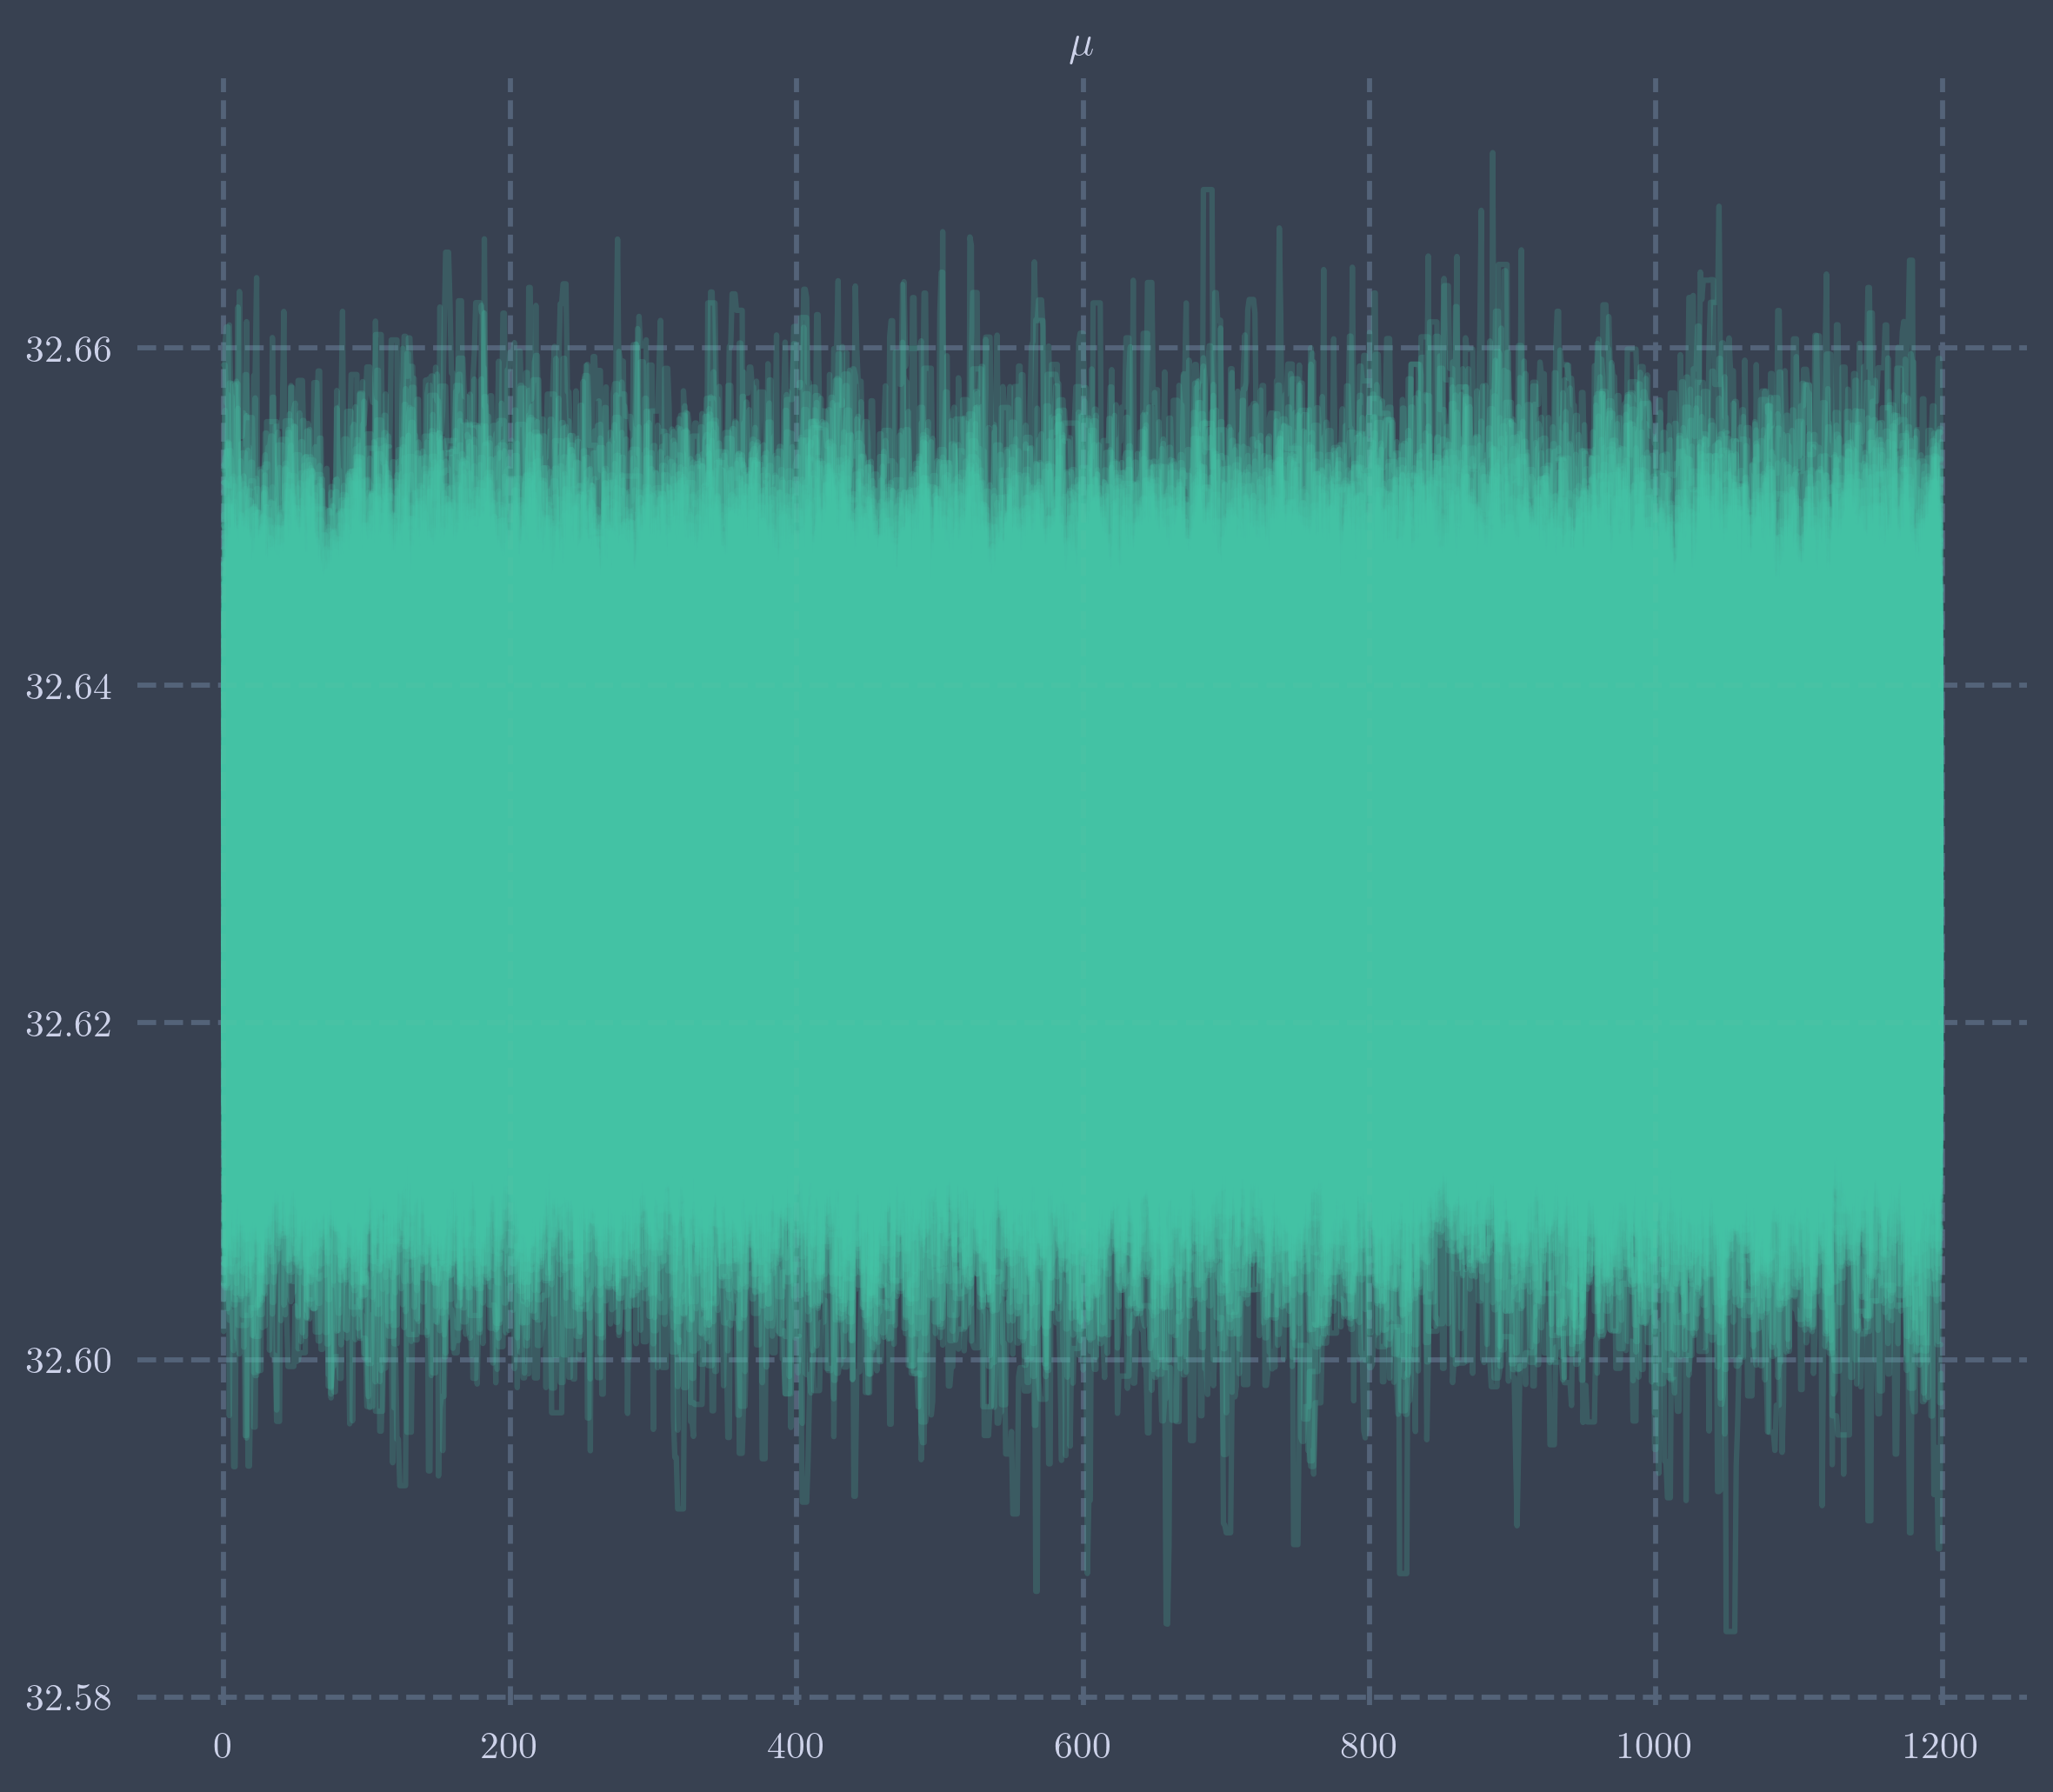

In [23]:
param_names = [r'$\mu$']
colors = ['#5b99e2', '#48c7a9']
fig,ax = plt.subplots(1, sharex=True)
for i in range(1):
    ax.plot(sampler.chain[:, :, i].T, color=colors[1], alpha=0.2)
    ax.set_title(param_names[i])

In [24]:
cm_samples_to_plot = sampler.chain[:, 200:, :].reshape((-1, cm_ndim))

In [25]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, baryon_ndim, log_prob_bary, pool=pool)
    sampler.run_mcmc(baryon_pos, nsteps, progress=True)

100%|██████████| 1200/1200 [07:51<00:00,  2.55it/s]


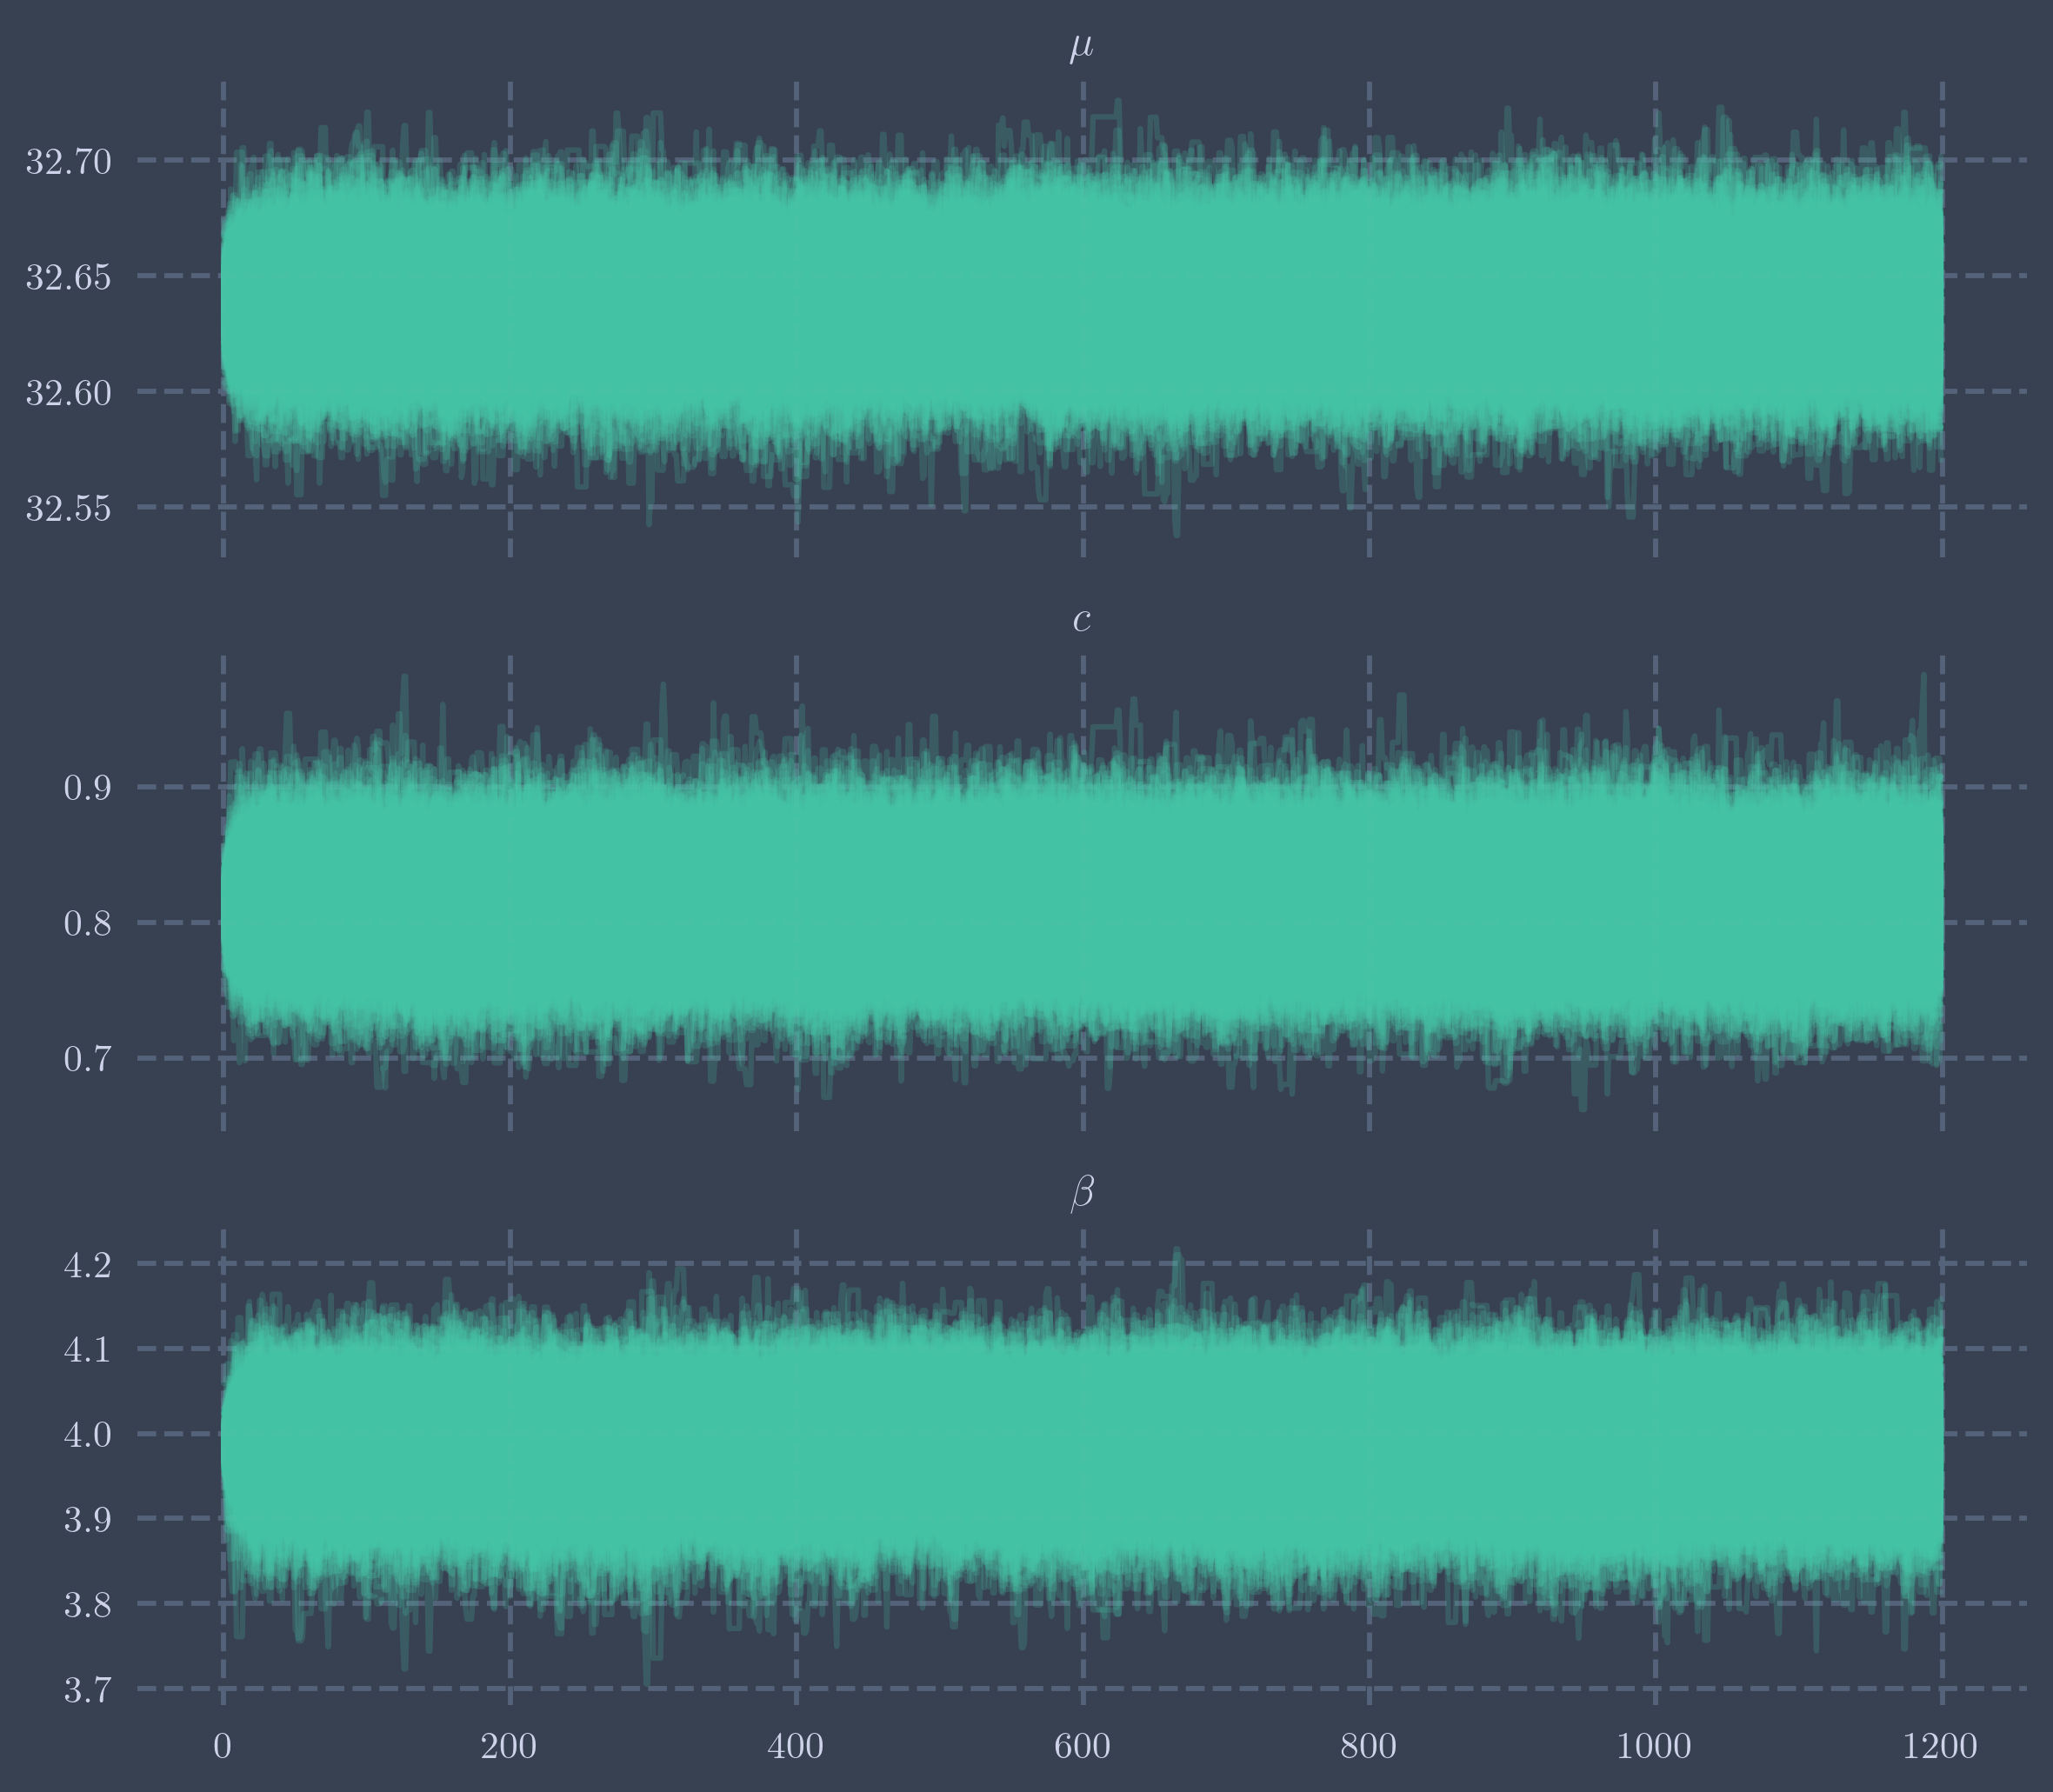

In [26]:
param_names = [r'$\mu$', r'$c$', r'$\beta$']
colors = ['#5b99e2', '#48c7a9']
fig,ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, color=colors[1], alpha=0.2)
    ax[i].set_title(param_names[i])

In [27]:
bary_samples_to_plot = sampler.chain[:, 200:, :].reshape((-1, baryon_ndim))

In [29]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, baryon_cm_ndim, log_prob_bary_cm, pool=pool)
    sampler.run_mcmc(baryon_cm_pos, nsteps, progress=True)

100%|██████████| 1200/1200 [21:11<00:00,  1.06s/it]


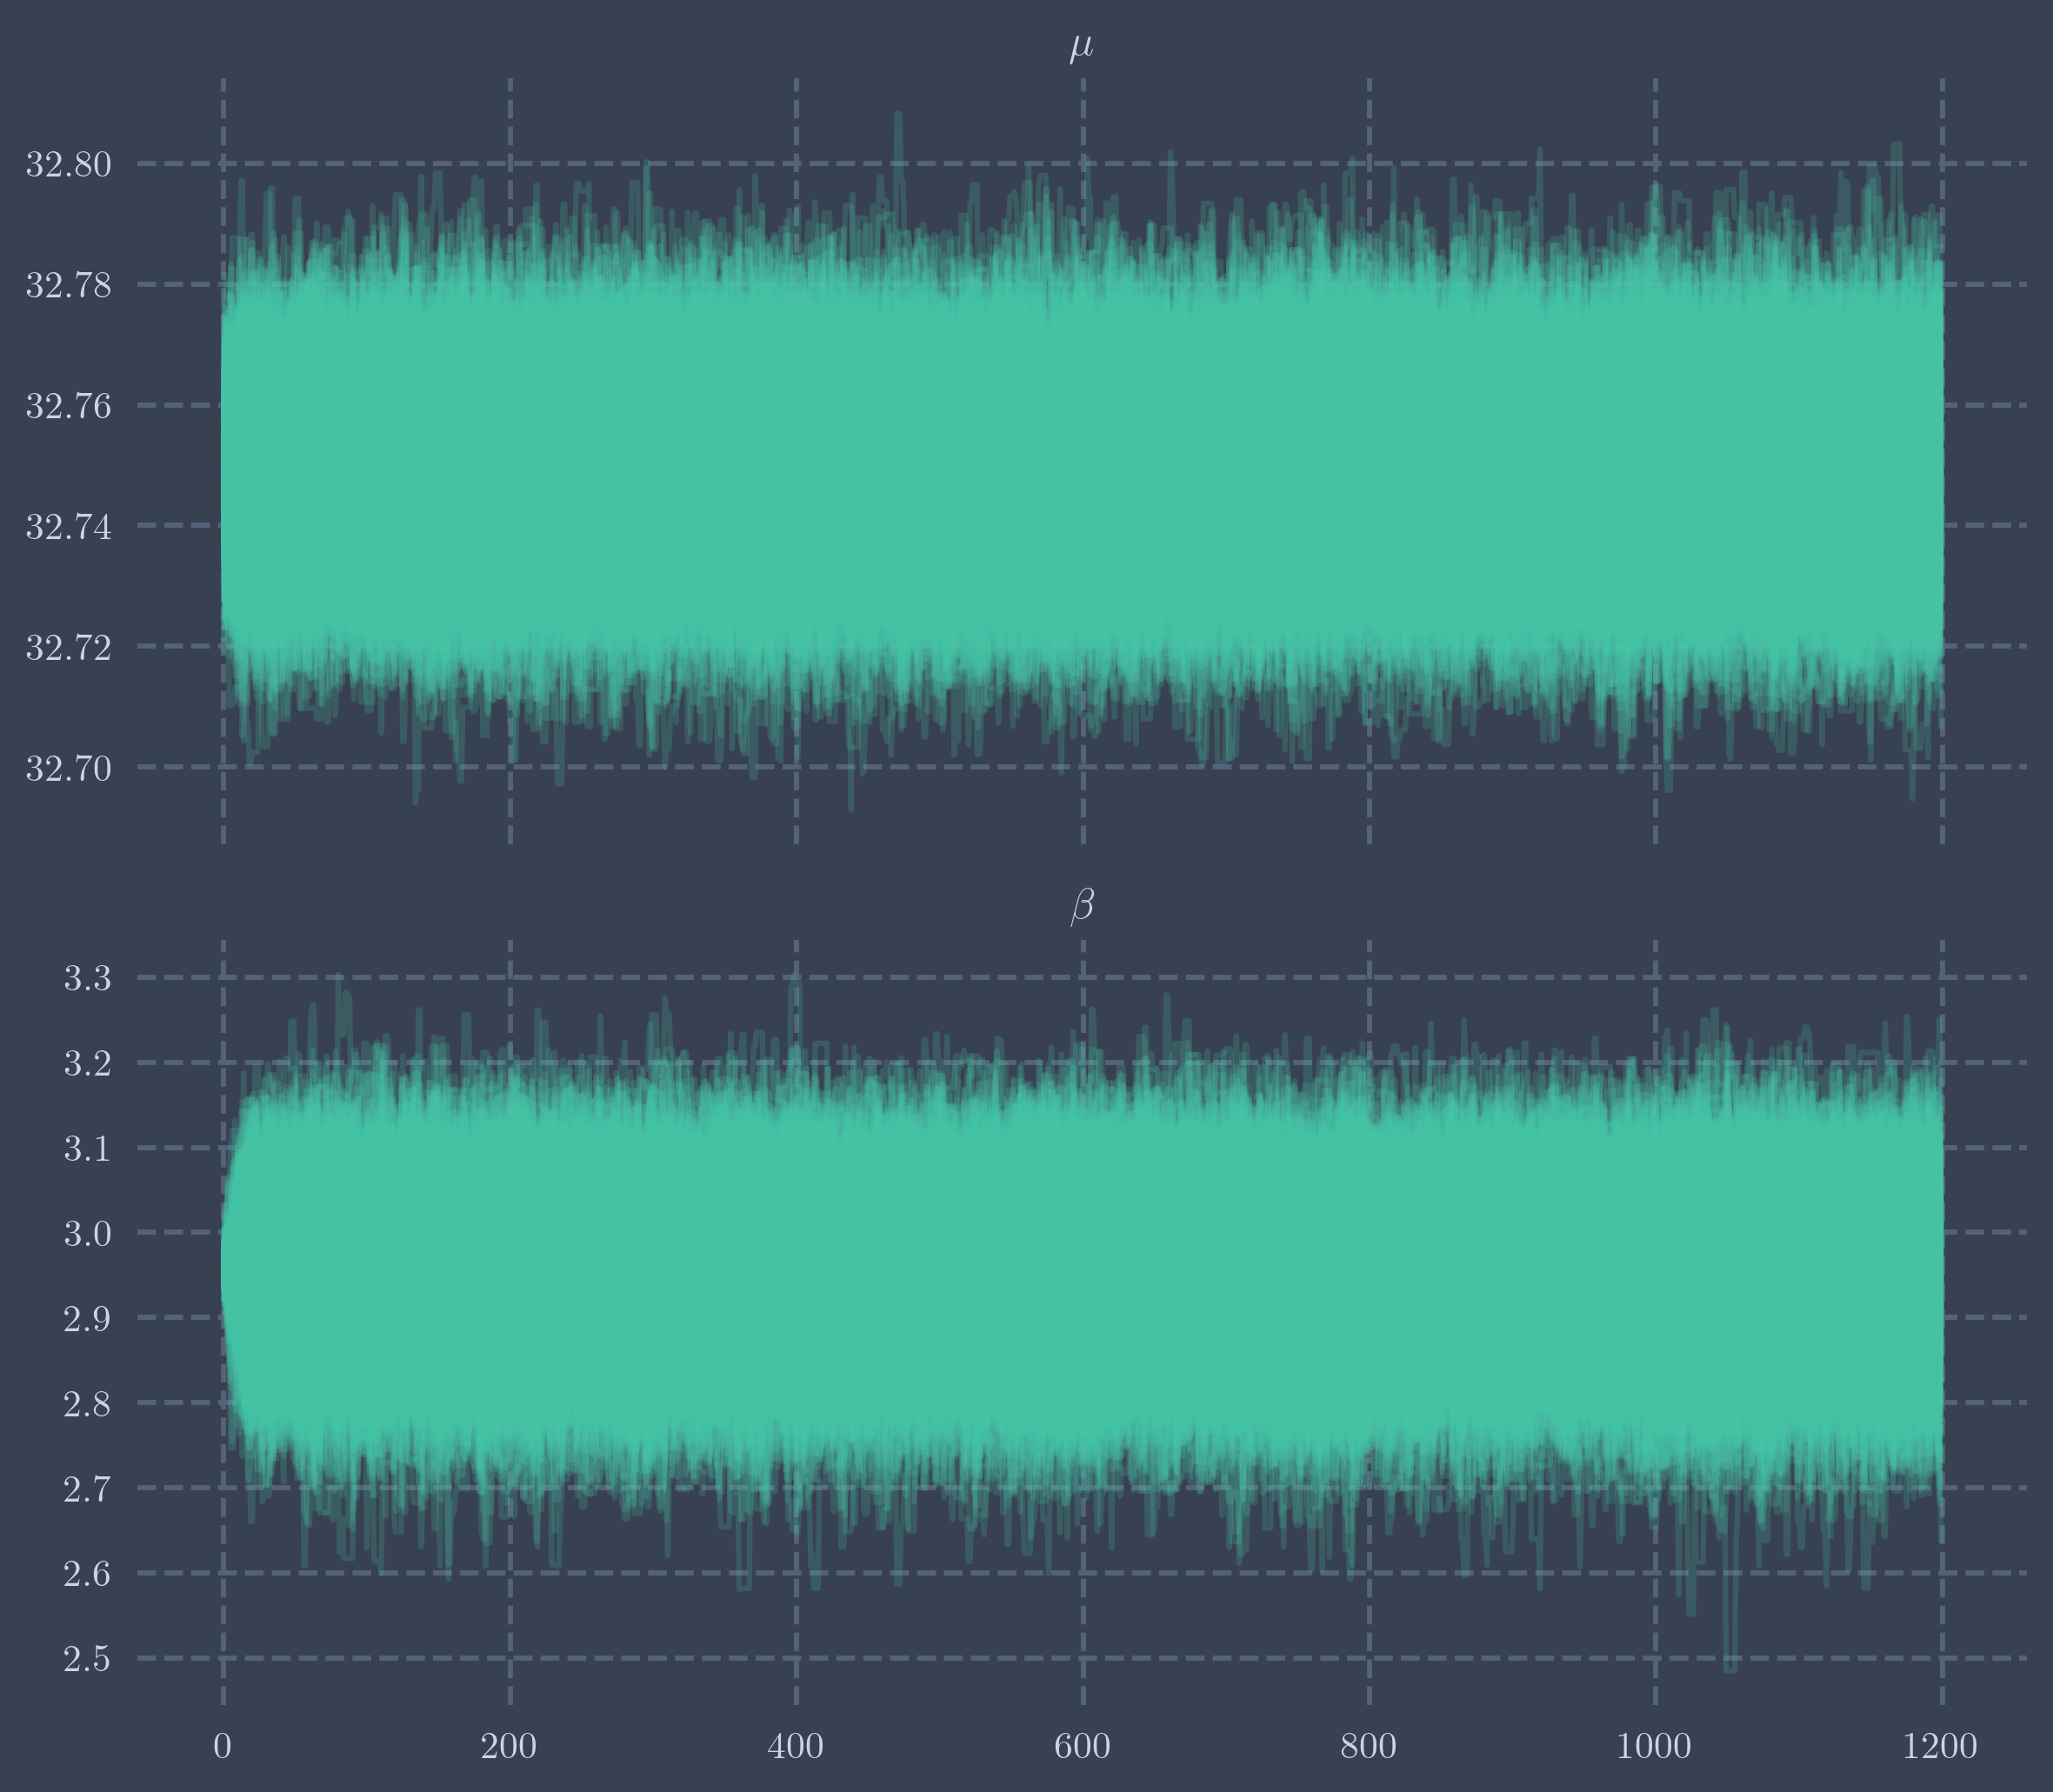

In [30]:
param_names = [r'$\mu$', r'$\beta$']
colors = ['#5b99e2', '#48c7a9']
fig,ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, color=colors[1], alpha=0.2)
    ax[i].set_title(param_names[i])

In [31]:
bary_cm_samples_to_plot = sampler.chain[:, 200:, :].reshape((-1, baryon_cm_ndim))

In [32]:
import corner

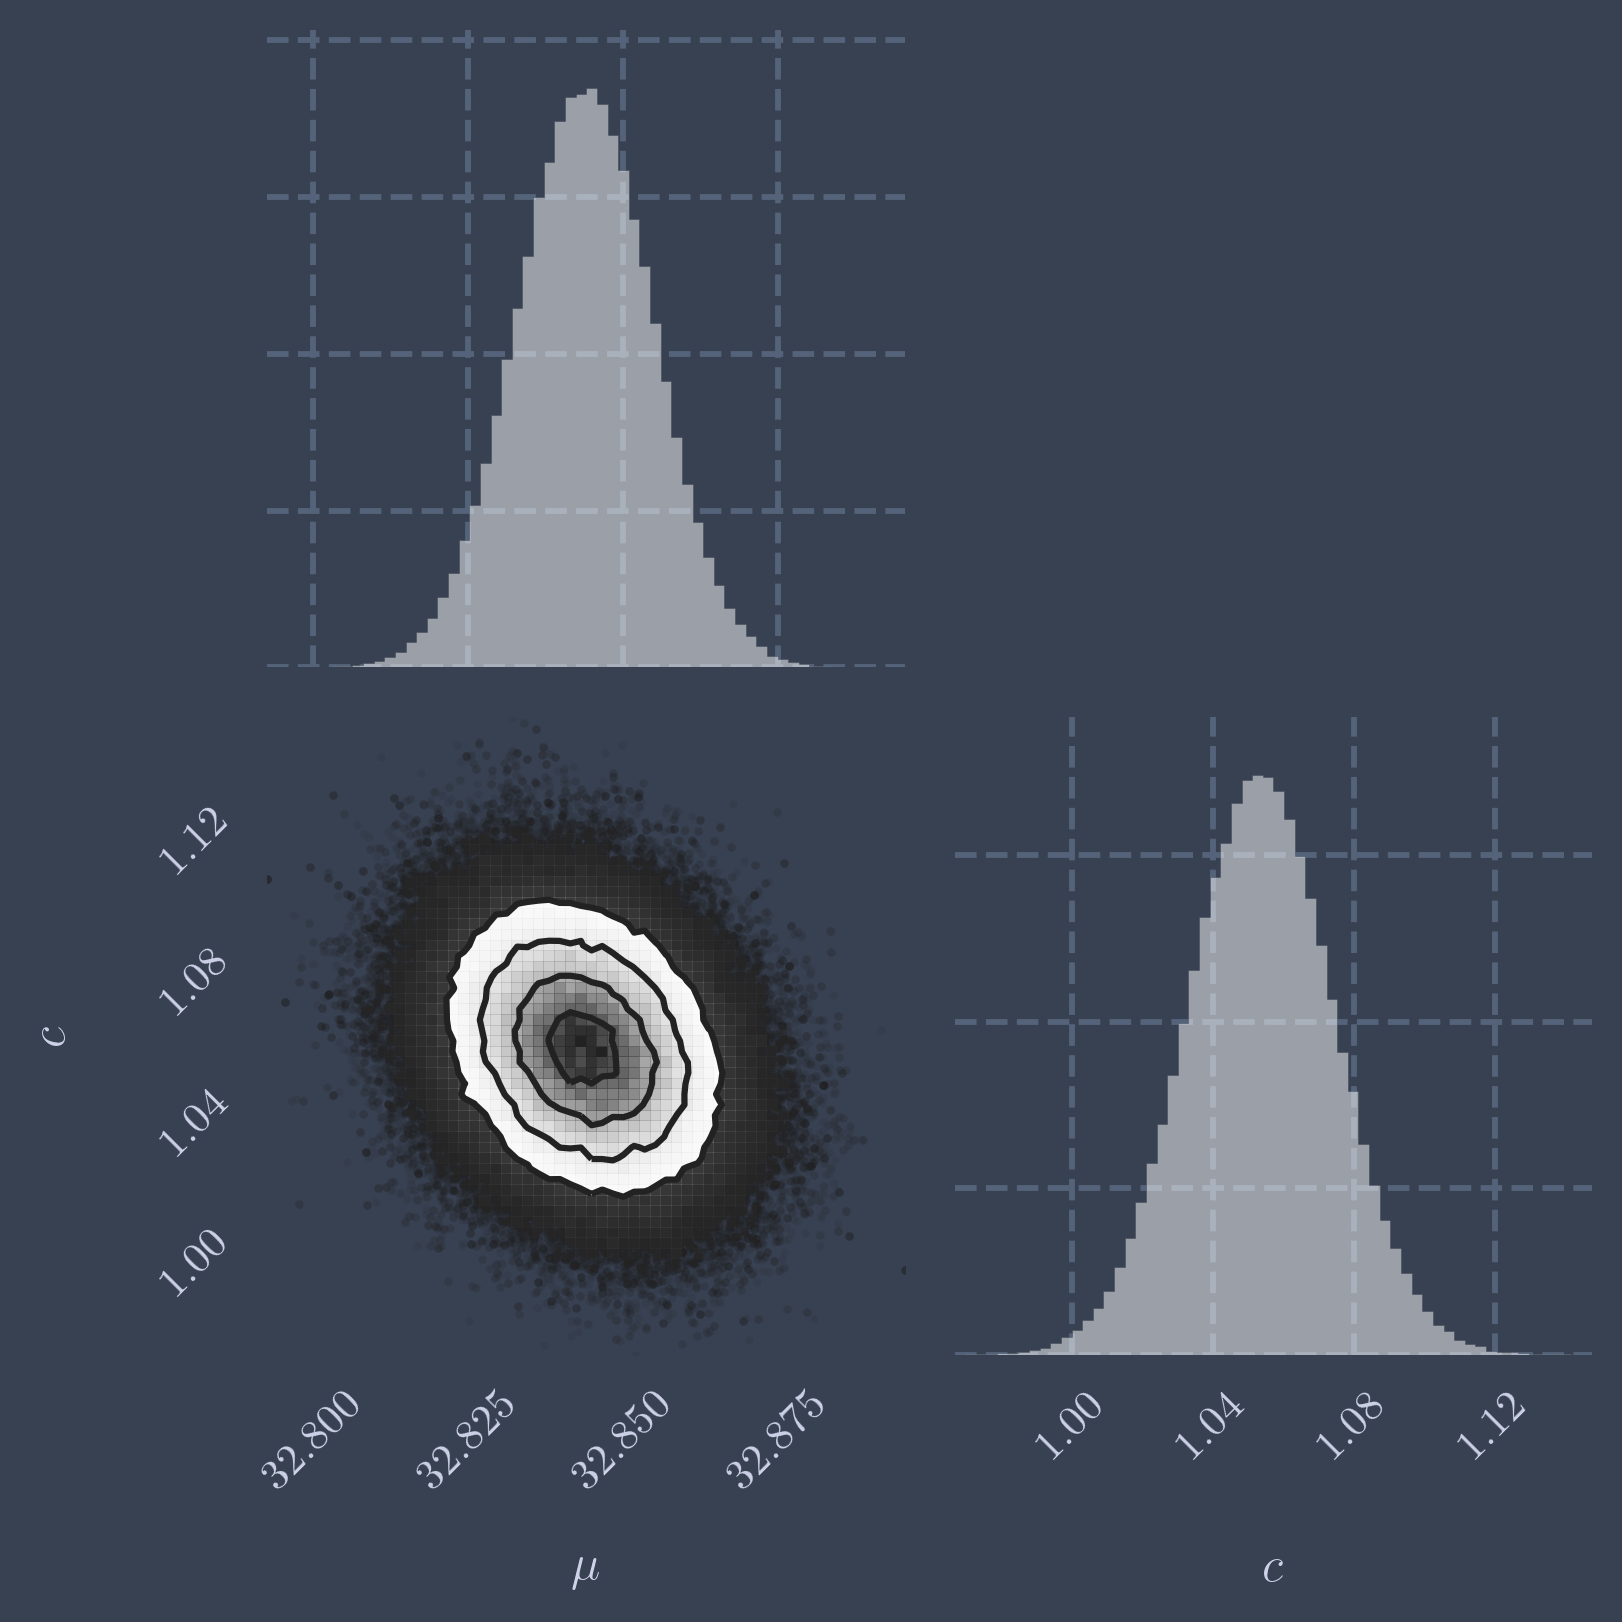

In [33]:
hist_kwargs = {'histtype':'stepfilled', 'alpha':0.5, 'color':'#ffffff'}
#hist2d_kwargs = {'cmap':cmap}
param_names = [r'$\mu$', r'$c$']
fig = corner.corner(nfw_samples_to_plot,
                    bins=60,
                    labels=param_names,
                    hist_kwargs=hist_kwargs)

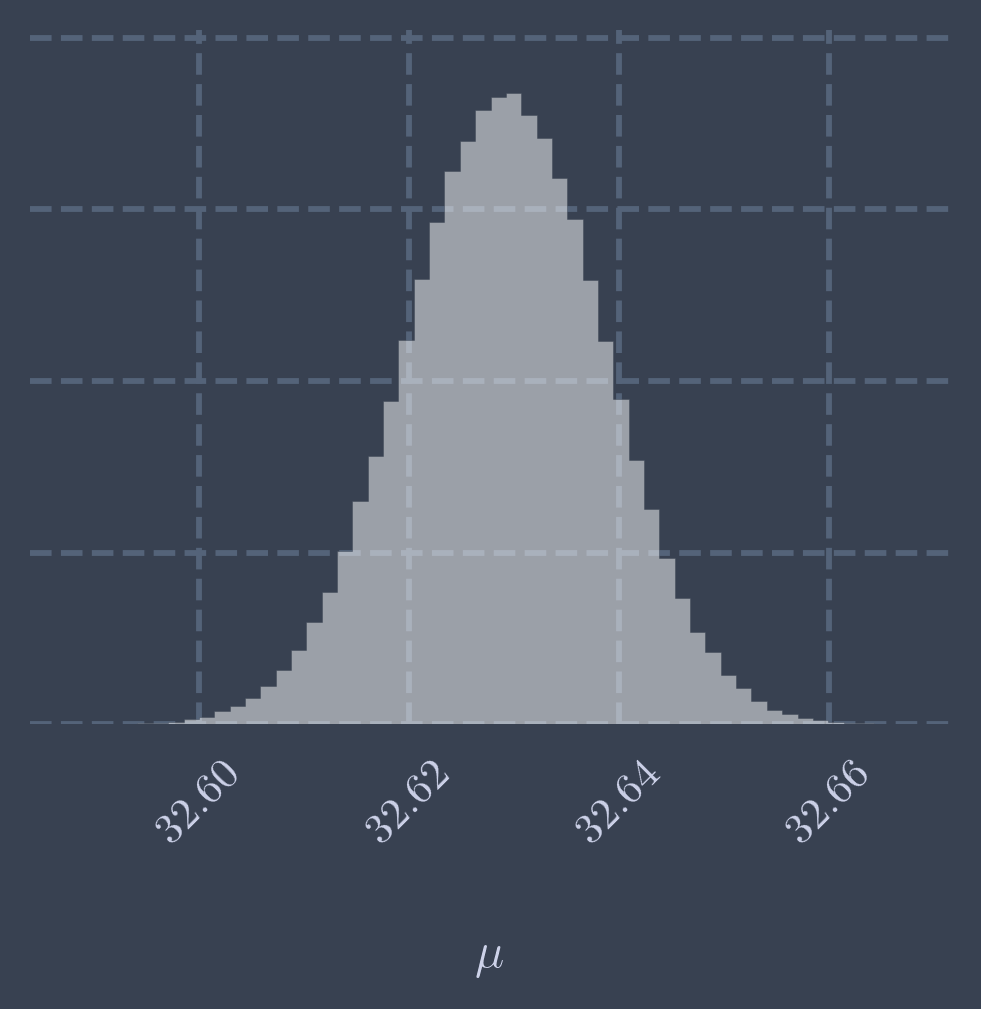

In [34]:
hist_kwargs = {'histtype':'stepfilled', 'alpha':0.5, 'color':'#ffffff'}
#hist2d_kwargs = {'cmap':cmap}
param_names = [r'$\mu$']
fig = corner.corner(cm_samples_to_plot,
                    bins=60,
                    labels=param_names,
                    hist_kwargs=hist_kwargs)

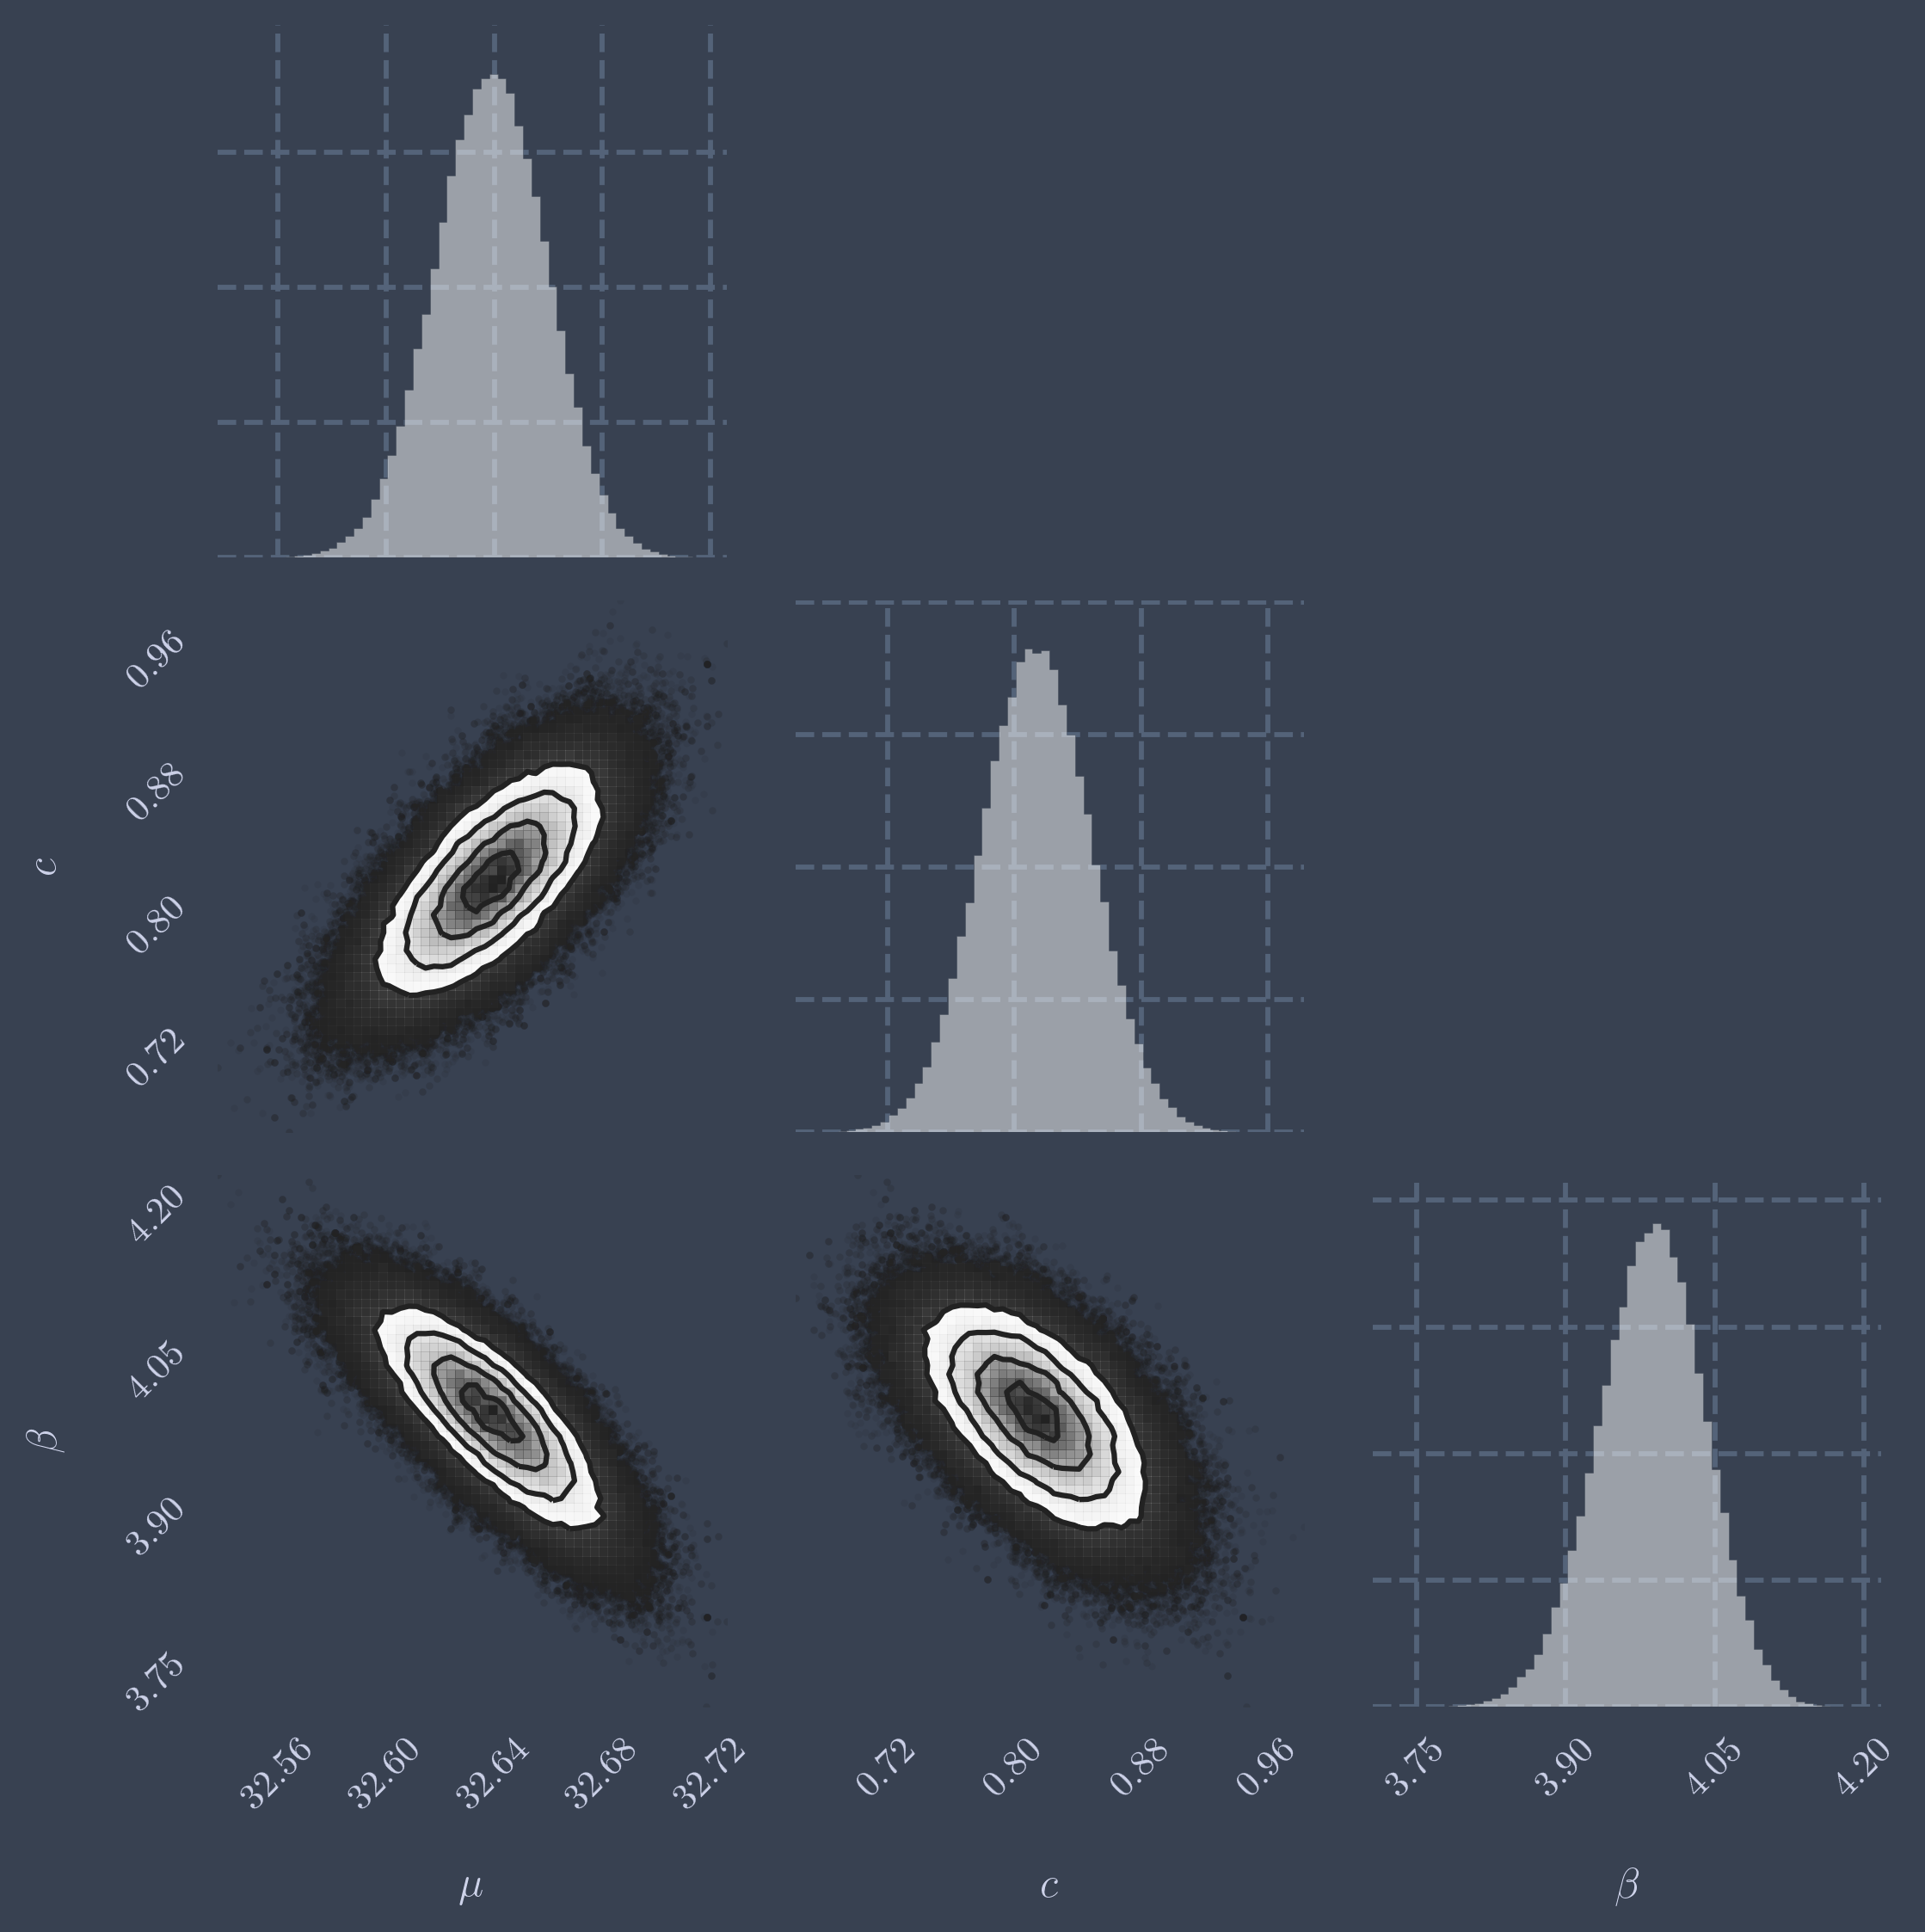

In [35]:
hist_kwargs = {'histtype':'stepfilled', 'alpha':0.5, 'color':'#ffffff'}
#hist2d_kwargs = {'cmap':cmap}
param_names = [r'$\mu$', r'$c$', r'$\beta$']
fig = corner.corner(bary_samples_to_plot,
                    bins=60,
                    labels=param_names,
                    hist_kwargs=hist_kwargs)

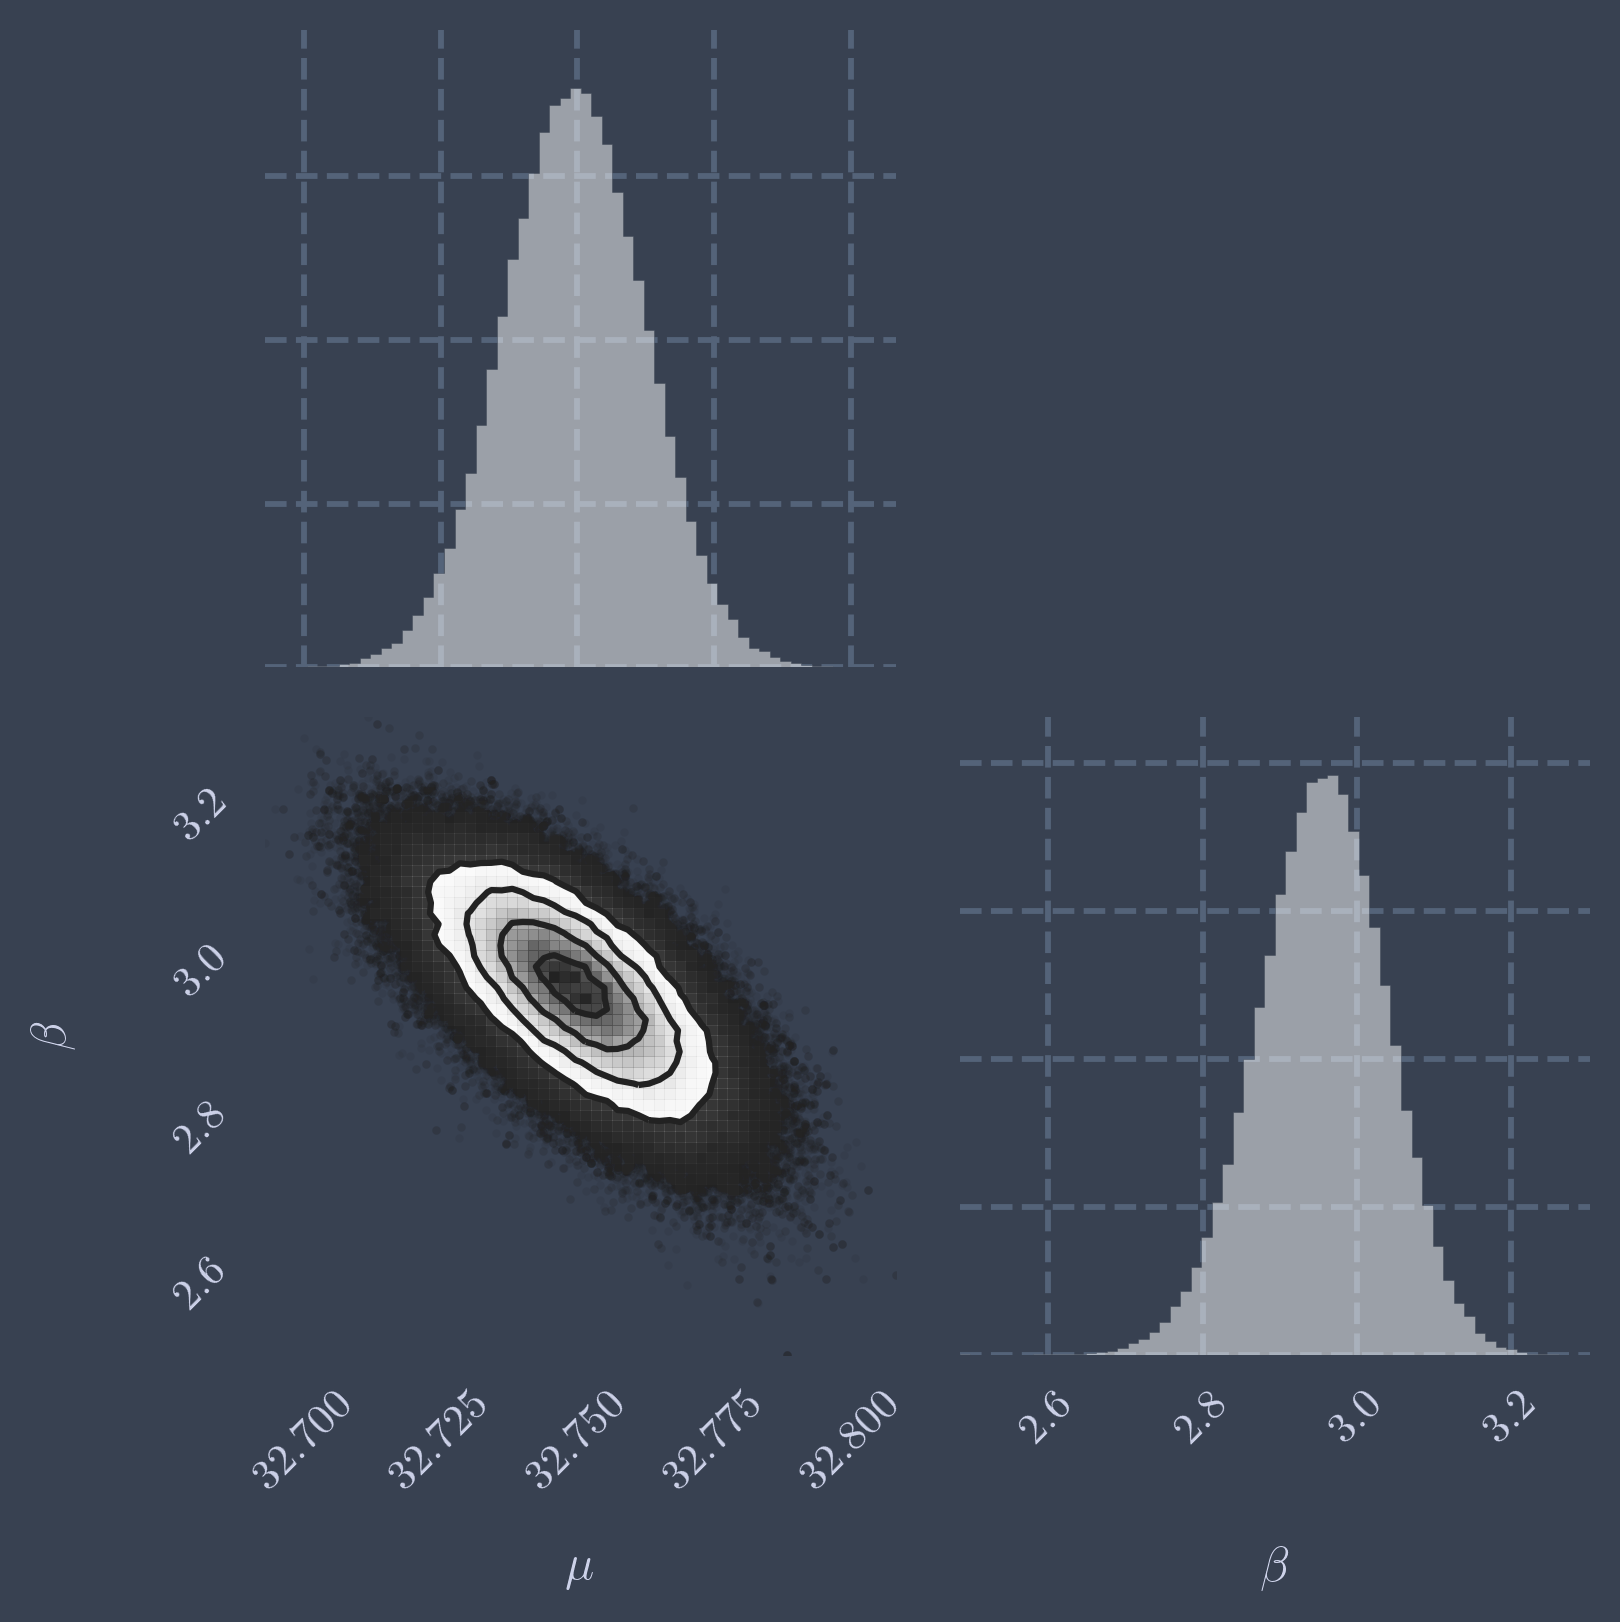

In [36]:
param_names = [r'$\mu$', r'$\beta$']
hist_kwargs = {'histtype':'stepfilled', 'alpha':0.5, 'color':'#ffffff'}
#hist2d_kwargs = {'cmap':cmap}
fig = corner.corner(bary_cm_samples_to_plot,
                    bins=60,
                    labels=param_names,
                    hist_kwargs=hist_kwargs)

In [37]:
def get_max(chain):
    hist = np.histogram(chain, bins=60)
    return (hist[1][hist[0].argmax()] + hist[1][hist[0].argmax()+1])/2

In [40]:
nfw_mu = get_max(nfw_samples_to_plot[:, 0])
nfw_con = get_max(nfw_samples_to_plot[:, 1])

nfw_p = np.array([nfw_mu, nfw_con])

cm_mu = get_max(cm_samples_to_plot[:, 0])
cm_p = np.array([cm_mu])

bary_mu = get_max(bary_samples_to_plot[:, 0])
bary_con = get_max(bary_samples_to_plot[:, 1])
bary_beta = get_max(bary_samples_to_plot[:, 2])
bary_p = np.array([bary_mu, bary_con, bary_beta])

bary_cm_mu = get_max(bary_cm_samples_to_plot[:, 0])
bary_cm_beta = get_max(bary_cm_samples_to_plot[:, 1])
bary_cm_p = np.array([bary_cm_mu, bary_cm_beta])

In [41]:
nfw_fit = nfw_model_func(rs, nfw_p).flatten()
cm_fit = cm_model_func(rs, cm_p).flatten()
bary_fit = baryon_model_func(rs, bary_p).flatten()
bary_cm_fit = baryon_cm_model_func(rs, bary_cm_p).flatten()

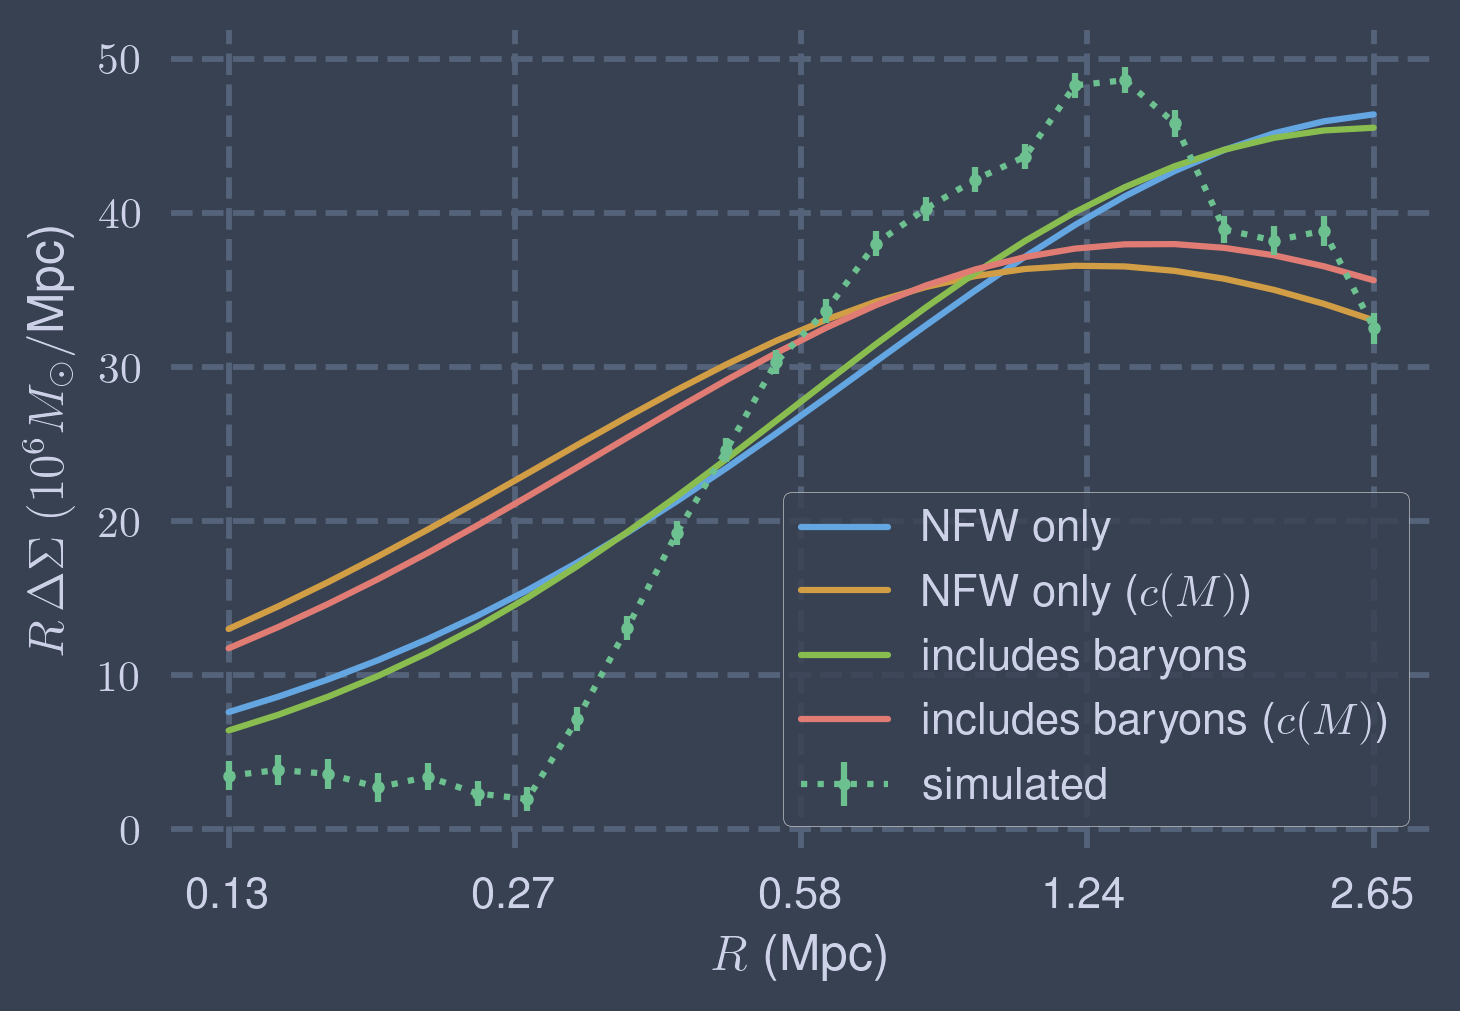

In [42]:
m_colors = ['#d19e45', '#63a6e2', '#8abd50', '#e17c74', '#6dc090']
resd_errs = np.sqrt(np.diag(act_r_esd_cov))

plt.plot(rs, rs*nfw_fit, label='NFW only', color=m_colors[1])
plt.plot(rs, rs*cm_fit, label=r'NFW only ($c(M)$)', color=m_colors[0])
plt.plot(rs, rs*bary_fit, label='includes baryons', color=m_colors[2])
plt.plot(rs, rs*bary_cm_fit, label=r'includes baryons ($c(M)$)', color=m_colors[3])

plt.errorbar(rs, rs*wl_data, yerr=resd_errs, capsize=2, zorder=3,
             marker='o', label='simulated', linestyle=':', markersize=3, color=m_colors[4])

plt.legend(loc='best')

plt.xlabel(r'$R$ (Mpc)')
plt.ylabel(r'$R \, \Delta \Sigma\; (10^6 M_\odot/$Mpc)')

plt.xscale('log')

plt.xscale('log')
plt.xticks(np.logspace(np.log10(rs[0]), np.log10(rs[-1]), 5))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.2f}')) # 2 decimal places

fig = plt.gcf()
fig.set_size_inches(5, 3.5)
pass


plt.savefig('../figs/sims/NBatta2010/single-mass-bin_best-fit-example_mcmc.pdf', bbox_inches='tight')

In [43]:
print(nfw_p, cm_p, bary_p, bary_cm_p, sep='\n')

[32.84492645  1.05260259]
[32.62992618]
[32.63969538  0.80889239  3.99129893]
[32.74965053  2.96880048]


In [44]:
print(np.exp(nfw_p[0])/1e14,
      np.exp(cm_p[0])/1e14,
      np.exp(bary_p[0])/1e14,
      np.exp(bary_cm_p[0])/1e14,
      sep='\n')

1.8381049937298206
1.482507448638821
1.497061343038501
1.6710617981941092
